## 路径

In [1]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

D:\project_meta\NNproject\NNI


In [2]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torchsummary import summary

In [3]:
class Residual1D(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
def resnet_block1d(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1D(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1D(num_channels, num_channels))
    return blk
featureNum=5
b1OutChannel=64
b2OutChannel=64
b3OutChannel=128
b4OutChannel=256
b5OutChannel=512
classNum=1
b1 = nn.Sequential(nn.Conv1d(featureNum, b1OutChannel, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block1d(b1OutChannel,b2OutChannel, 2, first_block=True))
b3 = nn.Sequential(*resnet_block1d(b2OutChannel, b3OutChannel, 2))
b4 = nn.Sequential(*resnet_block1d(b3OutChannel, b4OutChannel, 2))
b5 = nn.Sequential(*resnet_block1d(b4OutChannel, b5OutChannel, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum))
summary(net,(5,7680),batch_size=3,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 64, 3840]           2,304
       BatchNorm1d-2              [3, 64, 3840]             128
              ReLU-3              [3, 64, 3840]               0
         MaxPool1d-4              [3, 64, 1920]               0
            Conv1d-5              [3, 64, 1920]          12,352
       BatchNorm1d-6              [3, 64, 1920]             128
            Conv1d-7              [3, 64, 1920]          12,352
       BatchNorm1d-8              [3, 64, 1920]             128
        Residual1D-9              [3, 64, 1920]               0
           Conv1d-10              [3, 64, 1920]          12,352
      BatchNorm1d-11              [3, 64, 1920]             128
           Conv1d-12              [3, 64, 1920]          12,352
      BatchNorm1d-13              [3, 64, 1920]             128
       Residual1D-14              [3, 6

## 数据集

In [4]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDatasetIndex
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

info_table=pd.read_csv(output_path_dic["info_file"])


#随机分配
train_data_table,test_data_table=train_test_split(info_table,test_size=0.2,shuffle=True)

train_dataset=TableControlFullLoadDatasetIndex(train_data_table,data_root=data_root,output_root=output_root,Mintime=15)
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)

test_dataset=TableControlFullLoadDatasetIndex(test_data_table,data_root=data_root,output_root=output_root)
test_dataloader=DataLoader(test_dataset,batch_size=512)

In [5]:
next(iter(test_dataloader))[1]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 训练超参

In [6]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score
device=torch.device("cuda")
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=2000



## 权重存储路径

In [7]:

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)


D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_08_21_11_56


In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum)).to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.000001,weight_decay=5e-4)
loss=torch.nn.MSELoss().to(device="cuda")

KeyboardInterrupt: 

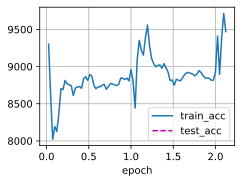

In [10]:

animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
timer, num_batches = d2l.Timer(), len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict[0]["data"].to(torch.float32).to(device)     
        y=data_dict[1].to(torch.float32).to(device)
        y_hat=net(x)
        l=loss(y_hat, y)
        l.backward()
        optim.step()     
        #pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        #num_true=sum(pre==y.cpu())
        print(l)
        print(y[0],y_hat[0])
        metric_train.add(l.detach().cpu(),y.numel())
        if (i + 1) % (num_batches //25) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
    
    # net.eval()
    # metric_test = d2l.Accumulator(2)
    # for data_dict in test_dataloader:
    #     x=data_dict["data"].to(torch.float32).to(device)
    #     y=data_dict["LEVEL"].long().to(device)
    #     y_hat=net(x)
    #     pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    #     num_true=sum(pre==y.cpu())
    #     metric_test.add(num_true,y.numel())
    # animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    # stagnate_times=stagnate_times+1
    # if best_test_acc<(metric_test[0]/metric_test[1]):
    #     best_test_acc=metric_test[0]/metric_test[1]
    #     stagnate_times=0
    #     torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
    # if temp_acc<metric_test[0]/metric_test[1]:
    #     stagnate_times=0 
    # temp_acc= metric_test[0]/metric_test[1]          
    # if stagnate_times>20:
    #     break

In [ ]:
len(info_table)

3347